In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import arff
import pandas as pd
import umap.umap_ as umap
from scipy.optimize import fsolve
from math import exp
from datetime import datetime



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




In [2]:
# ---------------------------------------------------------------------------- #
#                               my nonlinear SVM                               #
# ---------------------------------------------------------------------------- #

class my_nonlinear_SVM:
    
    def __init__(self, learning_rate=0.0001, trade_off=100, n_iters=50000, gamma=0.001, n_samples=0, kernel='rbf'):
        self.learning_rate = learning_rate
        self.trade_off = trade_off
        self.n_iters = n_iters
        self.gamma = gamma
        self.n_samples = n_samples
        self.kernel = kernel
        self.minority_coeff_c = 1
        self.momentum_vector = np.empty(n_samples)
    
    # ----------------------------- Gradient Descent ----------------------------- #
    def train_with_GD(self, X, Y, momentum_update=0):
        # n_samples, n_features = X.shape
        alphas = np.zeros(self.n_samples)
        mu = 0.0

        minority = check_minority_class(Y)
        for i in range(len(Y)):
            if Y[i] == minority:
                self.momentum_vector[i] += 0.1 * momentum_update
                # self.momentum_vector[i] += 0
            else:
                self.momentum_vector[i] = 0
        momentum_trade_off = (self.minority_coeff_c + self.momentum_vector) * self.trade_off

        kernel_matrix = self.compute_kernel_matrix(X)

        for _ in range(self.n_iters):
            condition = Y * (np.dot(kernel_matrix, alphas * Y)) >= 1
            if np.all(condition):
                pass
            else:
                alphas -= self.learning_rate * ((0.5 * Y) * np.dot(kernel_matrix, alphas * Y) - 1 + mu * Y)
                alphas = np.clip(alphas, 0, None)
                for i in range(len(alphas)):
                    alphas[i] = min(alphas[i], momentum_trade_off[i])
                mu -= self.learning_rate * np.dot(alphas, Y)

        support_vector_indices = alphas > 0

        self.alphas_SV = alphas[support_vector_indices]

        print("when training: ", self.alphas_SV)

        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = Y[support_vector_indices]

        eq_check = np.dot(alphas, Y)
        # print("eq_check: ", eq_check)

    # ------------------------------------ KKT ----------------------------------- #
    def train_with_KKT(self, X, Y, momentum_update=0):

        kernel_matrix = self.compute_kernel_matrix(X)
        # self.momentum_vector = np.empty(len(Y))

        minority = check_minority_class(Y)
        for i in range(len(Y)):
            if Y[i] == minority:
                # self.momentum_vector[i] += 10
                self.momentum_vector[i] += momentum_update
            else:
                self.momentum_vector[i] = 0
        momentum_trade_off = (self.minority_coeff_c + self.momentum_vector) * self.trade_off
        # print(max(self.momentum_vector))
        # print(max(momentum_trade_off))
        # print(momentum_trade_off)

        coeff_top_left = 0.5 * (Y.T * Y) * kernel_matrix
        coeff_top_right = Y.reshape(-1, 1)
        coeff_bottom_left = Y.reshape(1, -1)
        coeff_bottom_right = np.array([0]).reshape(1, 1)

        coeff_top = np.concatenate((coeff_top_left, coeff_top_right), axis = 1)
        coeff_bottom = np.concatenate((coeff_bottom_left, coeff_bottom_right), axis = 1)
        coeff = np.concatenate((coeff_top, coeff_bottom), axis = 0)

        if np.linalg.det(coeff) != 0:
            inv_coeff = np.linalg.inv(coeff)
        else:
            inv_coeff = np.linalg.pinv(coeff)
        RHS = np.ones(coeff.shape[0])
        RHS[-1] = 0
        RHS = RHS.reshape(-1, 1)

        alphas_and_mu = np.dot(inv_coeff, RHS)
        alphas = alphas_and_mu[:-1]
        mu = alphas_and_mu[-1]

        eq_check = np.dot(alphas.flatten(), Y)
        # print(eq_check)

        alphas = alphas.flatten()
        alphas = np.clip(alphas, 0, None)
        for i in range(len(alphas)):
            alphas[i] = min(alphas[i], momentum_trade_off[i])
        support_vector_indices = alphas > 0

        self.alphas_SV = alphas[support_vector_indices]

        # print("when training: ", max(self.alphas_SV))

        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = Y[support_vector_indices]

    # ------------------------------- kernel matrix ------------------------------ #
    def compute_kernel_matrix(self, X1, X2=None):
        if self.kernel == 'rbf':
            if X2 is None:
                X2 = X1
                
            pairwise_dists = np.linalg.norm(X1[:, np.newaxis] - X2, axis=-1)
            kernel_matrix = np.exp(-self.gamma * pairwise_dists**2)

        elif self.kernel == 'linear':
            if X2 is None:
                X2 = X1
                
            kernel_matrix = np.dot(X1, X2.T)

        else:
            raise ValueError("Unsupported Kernel Type")
                
        return kernel_matrix
    
    # -------------------------------- prediction -------------------------------- #
    def predict(self, X, Y_known=None, momentum_update=0):
        n_samples, n_features = X.shape
        Y = np.empty(n_samples)

        kernel_matrix = self.compute_kernel_matrix(X, self.support_vectors)

        # print("when predicting: ", max(self.alphas_SV))

        Y = np.sign(np.dot(kernel_matrix, self.alphas_SV * self.support_vector_labels))

        return Y

In [3]:
def plot_umap(features, y):

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='cool', s = 0.5)
    classes = ['benign', 'malignant']
    
    cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
    cbar.set_ticks(np.arange(2))
    cbar.set_ticklabels(classes)

    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('UMAP Visualization')
    plt.show()

In [4]:
def accuracy(Y_true, Y_pred):
    minority = check_minority_class(Y)
    majority = -minority

    num_majority = np.count_nonzero(Y_true == majority)
    num_minority = np.count_nonzero(Y_true == minority)
    
    # print("==================")
    # print("majority: ", majority)
    # print("majority class: ", num_majority)
    # print("minority: ", minority)
    # print("minority class: ", num_minority)

    maj_accuracy = np.sum((Y_true == majority) & (Y_pred == majority)) / num_majority
    min_accuracy = np.sum((Y_true == minority) & (Y_pred == minority)) / num_minority
    overall_accuracy = np.sum(Y_true == Y_pred) / len(Y_true)

    return overall_accuracy, maj_accuracy, min_accuracy

# ---------------------------- plot SVM boundaries --------------------------- #
def plot_decision_boundary(clf, X_train, Y_train, X_test, Y_test, figsize=(10, 7)):
    # Create a mesh grid for plotting
    xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 400),
                        np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 400))

    # Predict labels for each point in the mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and data points
    plt.figure(figsize = figsize)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.4)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.coolwarm, marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.coolwarm, marker='*')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary of the SVM")
    plt.show()

# ----------------------------- plot data points ----------------------------- #
def visualize_data_points(X, Y):
    # Separate the coordinates based on their labels
    X_label_0 = X[Y == -1]
    X_label_1 = X[Y == 1]

    # Plot the coordinates and color them based on the labels
    plt.scatter(X_label_0[:, 0], X_label_0[:, 1], c='blue', label='Negative Class')
    plt.scatter(X_label_1[:, 0], X_label_1[:, 1], c='red', label='Positive Class')

    # Add labels and legend
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Plot of Coordinates with Color-Coded Labels')
    plt.legend()

    # Show the plot
    plt.show()

# -------------------------------- data loader ------------------------------- #
def load_arff(imported_file_name):
    arff_file = imported_file_name + '.arff'
    with open(arff_file, 'r') as file:
        data = arff.load(file)
        df = pd.DataFrame(data['data'])
    return df

def load_File(imported_file_name):
    arff_file = imported_file_name
    with open(arff_file, 'r') as file:
        data = arff.load(file)
        df = pd.DataFrame(data['data'])
    return df

# ---------------------------------- masking --------------------------------- #
def mask_minority_class(minority_to_majority_ratio, X, Y):
    num_neg_ones = np.count_nonzero(Y == -1)
    num_ones = np.count_nonzero(Y == 1)
    
    minority = check_minority_class(Y)
        
    num_samples_to_remove = int(min(num_neg_ones, num_ones) - minority_to_majority_ratio * (max(num_neg_ones, num_ones)))
    if num_samples_to_remove < 0:
        num_samples_to_remove = 0

    indices = np.where(Y == minority)[0]
    indices_to_remove = np.random.choice(indices, size=num_samples_to_remove, replace=False)
    mask = np.ones_like(Y_train, dtype=bool)
    mask[indices_to_remove] = False
    Y = Y[mask]
    X = X[mask]

    return X, Y

# ---------------------- train, validation, testr split ---------------------- #
def perform_split(X, Y, prev_seed=None, split_ratio=0.1):
    
    if prev_seed is not None:
        seed = prev_seed
    else:
        seed = np.random.randint(0, 100)
    print("Seed:", seed)

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=split_ratio, random_state=seed
    )
            
    X_train, X_validation, Y_train, Y_validation = train_test_split(
        X_train, Y_train, test_size=(split_ratio / (1 - split_ratio)), random_state=seed
    )

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation, seed

# -------------------- check minority and majority classes ------------------- #
def check_minority_class(Y):
    num_neg_ones = np.count_nonzero(Y == -1)
    num_ones = np.count_nonzero(Y == 1)

    minority = 0
    if num_ones == max(num_neg_ones, num_ones):
        minority = -1
    else:
        minority = 1

    return minority

Seed: 62


Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress: 100%|██████████| 1000/1000 [00:07<00:00, 127.99it/s, momentum_check=5e-324, train_maj=0.998, train_min=1]


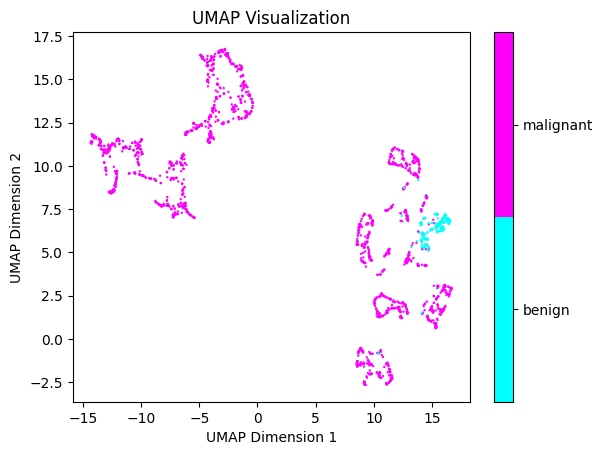

In [5]:
if __name__ == "__main__":

    # ------------------------------- main program ------------------------------- #
    
    #  =============================================================================
    # ---------------------------------------------------------------------------- #
    #                                  User Inputs                                 #
    # ---------------------------------------------------------------------------- #
    class_ratio = 0.1

    # dataset = 'cancer'
    dataset = 'gender'

    # mode = 'tune'
    mode = 'run'

    prev_seed = None
    num_momentum_update_iterations = 1000
    
    method = 'KKT'
    # method = 'GD'

    #  =============================================================================
    #  =============================================================================

    dataset_name = ''

    if dataset == 'cancer':
        df = load_arff(dataset)
    elif dataset == 'gender':
        df = load_File(dataset)
    else:
        raise ValueError("Use 'cancer' or 'gender'.")

    X = df.iloc[:, :-1].values

    if dataset == 'cancer':
        Y_original = df.iloc[:, -1].values.astype(float)
        Y = np.where(Y_original == 2, -1, 1)
    elif dataset == 'gender':
        Y_original = df.iloc[:, -1].values
        Y = np.where(Y_original == 'Male', -1, 1)
    else:
        raise ValueError("Use 'cancer' or 'gender'.")

    X_train, Y_train, X_test, Y_test, X_validation, Y_validation, seed = perform_split(X, Y, prev_seed=prev_seed, split_ratio=0.1)
    X_train, Y_train = mask_minority_class(class_ratio, X_train, Y_train)
    n_samples, n_features = X_train.shape

    lr_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
    to_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    gm_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    # lr_values = [0.0001]
    # to_values = [0.001]
    # gm_values = [10]

    results = []
    counter = 0
    total_iterations = len(lr_values) * len(to_values) * len(gm_values)

    if mode == 'tune':
        # ------------------------- hyperparameter selection ------------------------- #
        with tqdm(total=total_iterations, desc="Progress") as pbar:
            for learning_rate in lr_values:
                for trade_off in to_values:
                    for gamma in gm_values:
                        counter += 1
                        clf = my_nonlinear_SVM(learning_rate=learning_rate, trade_off=trade_off, n_iters=2000, gamma=gamma, n_samples=n_samples, kernel='rbf')
                        if method == 'GD':
                            clf.train_with_GD(X_train, Y_train)
                        elif method == 'KKT':
                            clf.train_with_KKT(X_train, Y_train)
                        else:
                            raise ValueError("Use 'KKT' or 'GD'.")

                        predictions_train = clf.predict(X_train, momentum_update=momentum_update)
                        predictions_validation = clf.predict(X_validation, momentum_update=momentum_update)

                        acc_train, acc_train_maj, acc_train_min = accuracy(Y_train, predictions_train)
                        acc_validation, acc_validation_maj, acc_validation_min = accuracy(Y_validation, predictions_validation)

                        result = {'counter':counter, 'learning_rate': learning_rate, 'trade_off': trade_off, 'gamma': gamma, 
                                'train_overall': acc_train, 'train_majority': acc_train_maj, 'train_minority': acc_train_min, 
                                'validation_overall': acc_validation, 'validation_majority': acc_validation_maj, 'validation_minority': acc_validation_min}
                        results.append(result)

                        pbar.set_postfix(learning_rate=learning_rate, trade_off=trade_off, gamma=gamma, acc_train=acc_train, acc_validation=acc_validation)
                        pbar.update(1)

        print("Train set accuracy: overall:{}, majority:{}, minority:{}".format(acc_train, acc_train_maj, acc_train_min))
        print("Validation set accuracy: overall:{}, majority:{}, minority:{}".format(acc_validation, acc_validation_maj, acc_validation_min))
        
        csv_file = 'results_on_{}_dataset_with_seed_{}_and_{}.csv'.format(dataset, seed, method)
        with open(csv_file, 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=['counter', 'learning_rate', 'trade_off', 'gamma', 'train_overall', 'train_majority', 'train_minority', 'validation_overall', 'validation_majority', 'validation_minority'])
            writer.writeheader()
            writer.writerows(results)

        print("Results exported to", csv_file)
        # ---------------------------------- results --------------------------------- #
    elif mode == 'run':
        momentum_update = 0

        # gender set with KKT
        learning_rate = 0.0001
        trade_off = 0.001
        gamma = 10

        # cancer set with KKT
        # learning_rate = 0.0001
        # trade_off = 0.001
        # gamma = 0.001

        clf = my_nonlinear_SVM(learning_rate=learning_rate, trade_off=trade_off, n_iters=2000, gamma=gamma, n_samples=n_samples, kernel='rbf')
        with tqdm(total=num_momentum_update_iterations, desc="Progress") as pbar:
            for _ in range(num_momentum_update_iterations):
                counter += 1
                if (_ == 0) or (_ > 0 and momentum_update != 0):
                    if method == 'GD':
                        clf.train_with_GD(X_train, Y_train, momentum_update=momentum_update)
                    elif method == 'KKT':
                        clf.train_with_KKT(X_train, Y_train, momentum_update=momentum_update)
                    else:
                        raise ValueError("Use 'KKT' or 'GD'.")
                    
                    predictions_train = clf.predict(X_train)
                    predictions_validation = clf.predict(X_validation)
                    predictions_test = clf.predict(X_test)

                    acc_train, acc_train_maj, acc_train_min = accuracy(Y_train, predictions_train)
                    acc_validation, acc_validation_maj, acc_validation_min = accuracy(Y_validation, predictions_validation)
                    acc_test, acc_test_maj, acc_test_min = accuracy(Y_test, predictions_test)

                    momentum_update = max(acc_train_maj - acc_train_min, 0)
                    
                    # print("Train set accuracy: overall:{}, majority:{}, minority:{}".format(acc_train, acc_train_maj, acc_train_min))
                    # print("Test set accuracy: overall:{}, majority:{}, minority:{}".format(acc_test, acc_test_maj, acc_test_min))
                
                result = {'counter':counter, 'momentum': momentum_update, 'accum_momentum':max(clf.momentum_vector), 'train_majority': acc_train_maj, 'train_minority': acc_train_min, 
                          'test_majority': acc_test_maj, 'test_minority': acc_test_min}
                results.append(result)

                if _ == (num_momentum_update_iterations - 1): 
                    predictions_train_UMAP = np.where(predictions_train == -1, 0, 1)
                pbar.set_postfix(momentum_check=max(clf.momentum_vector), train_maj=acc_train_maj, train_min=acc_train_min)
                pbar.update(1)

        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        csv_file = 'run_results_on_{}_dataset_with_seed_{}_and_{}_at_{}.csv'.format(dataset, seed, method, current_time)
        with open(csv_file, 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=['counter', 'momentum', 'accum_momentum', 'train_majority', 'train_minority', 'test_majority', 'test_minority'])
            writer.writeheader()
            writer.writerows(results)


        plot_umap(X_train, predictions_train_UMAP)
    else:
        raise ValueError("Use 'tune' or 'run'.")
